## NLP Project

github link: https://github.com/TrangNguyen95/NLP

Project purpose: Using Naive Bayes to build a spam classifier based on the fake_or_real_news dataset.

In [2]:
import numpy as np
import pandas as pd
import re
import nltk

In [3]:
import sklearn

In [4]:
from nltk.stem import WordNetLemmatizer
from sklearn.linear_model import LogisticRegression
from bs4 import BeautifulSoup

### Import Data

In [5]:
df_news=pd.read_csv('fake_or_real_news.csv')

In [6]:
df_news.head()

,Unnamed: 0,title,text,label
0,8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE
2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL
3,10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE
4,875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL


In [7]:
df_news.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6335 entries, 0 to 6334
Data columns (total 4 columns):
Unnamed: 0    6335 non-null int64
title         6335 non-null object
text          6335 non-null object
label         6335 non-null object
dtypes: int64(1), object(3)
memory usage: 198.0+ KB


### EDA

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

C:\Users\trangn\AppData\Local\Continuum\anaconda3\lib\site-packages\seaborn\categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


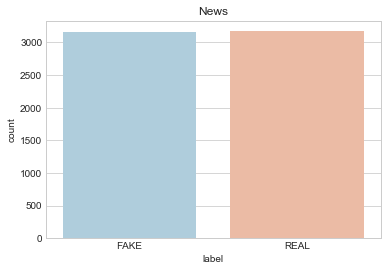

In [9]:
sns.set_style('whitegrid')
sns.countplot(x='label',data=df_news,palette='RdBu_r')
plt.title('News')
plt.show()

### Preprocessing

In [11]:
Fake=df_news[df_news['label']=="FAKE"].apply(lambda x: x.astype(str).str.lower())
Real=df_news[df_news['label']=="REAL"].apply(lambda x: x.astype(str).str.lower())

Fake_text_list=pd.DataFrame({'Text':Fake['text']}).values.tolist()
Real_text_list=pd.DataFrame({'Text':Real['text']}).values.tolist()

### Tokenizing text

In order to perform machine learning on text documents, we first need to turn the text content into numerical feature vectors.

In [12]:
# from http://www.lextek.com/manuals/onix/stopwords1.html
stopwords = set(w.rstrip() for w in open('stopwords.txt'))

In [13]:
wordnet_lemmatizer = WordNetLemmatizer()

In [15]:

def my_tokenizer(s):
    tokens = nltk.tokenize.word_tokenize(s) # split string into words (tokens)
    tokens = [t for t in tokens if len(t) > 2] # remove short words, they're probably not useful
    tokens = [wordnet_lemmatizer.lemmatize(t) for t in tokens] # put words into base form
    tokens = [t for t in tokens if t not in stopwords] # remove stopwords
    return tokens

In [16]:
word_index_map = {}
current_index = 0
Fake_tokenized = []
Real_tokenized = []

for news in Real_text_list:
    tokens = my_tokenizer(str(news))
    Real_tokenized.append(tokens)
    for token in tokens:
        if token not in word_index_map:
            word_index_map[token] = current_index
            current_index += 1

for news in Fake_text_list:
    tokens = my_tokenizer(str(news))
    Fake_tokenized.append(tokens)
    for token in tokens:
        if token not in word_index_map:
            word_index_map[token] = current_index
            current_index += 1


In [17]:
def tokens_to_vector(tokens, label):
    x = np.zeros(len(word_index_map) + 1) # last element is for the label
    for t in tokens:
        i = word_index_map[t]
        x[i] += 1
    x = x / x.sum() # normalize it before setting label
    x[-1] = label
    return x

N = len(Real_tokenized) + len(Fake_tokenized)
# (N x D+1 matrix - keeping them together for now so we can shuffle more easily later
data = np.zeros((N, len(word_index_map) + 1))
i = 0
for tokens in Real_tokenized:
    xy = tokens_to_vector(tokens, 1)
    data[i,:] = xy
    i += 1

for tokens in Fake_tokenized:
    xy = tokens_to_vector(tokens, 0)
    data[i,:] = xy
    i += 1

C:\Users\trangn\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  


### NB Classifier

In [19]:
#Clean out nan from data
Data_Clean=data[~np.isnan(data).any(axis=1)]

In [20]:
len(data)

6335

In [21]:
len(Data_Clean)

6299

In [22]:
np.random.shuffle(data)

X = Data_Clean[:,:-1]
Y = Data_Clean[:,-1]

# last 1000 rows will be test
Xtrain = X[:-1000,]
Ytrain = Y[:-1000,]
Xtest = X[-1000:,]
Ytest = Y[-1000:,]

In [23]:
from sklearn.naive_bayes import MultinomialNB

In [98]:
model = MultinomialNB()
model.fit(Xtrain, Ytrain)
print ("Classification rate for NB:", model.score(Xtest, Ytest))

Classification rate for NB: 0.834
